In [1]:
%run ./Genera_LIB_V5.ipynb

In [2]:
def carica_storico(file_name,uct_offset,type_session,resample_tf,IS,OOS,custom_session_start,custom_session_stop):
    import os
    import talib as ta
    
    os.chdir(dir_history)
    data = load_data_intraday_fast(file_name)  
    print("Caricato storico")
    data = data.sort_index(ascending=True)
    data.index = data.index.tz_localize('Etc/Zulu')
    data.index = data.index.tz_convert(uct_offset )
    data.index = data.index.tz_localize(None)
    data = data[data!=0]
    #data = data.fillna(method="ffill")
    data = data.iloc[1:-1]
    print("Resample dei dati")
    if type_session == 1:
        dataset=resample_custom_session("5min",resample_tf ,data,custom_session_start,custom_session_stop) 
    if type_session == 0:    
        dataset=resample_standard_session("5min",resample_tf,data)
        
    dataset = dataset.loc[IS:OOS]

    print("Fatto")
    return dataset 

In [3]:
def environment_fast(simbolo,type_session,resample_tf,start_date,end_date):
               
    file_name = check_history_name(simbolo,dir_history)

    IS = start_date
    OOS = end_date

    bigpointvalue=valori[valori.Physical==simbolo].BigPointValue.values[0]
    tick=valori[valori.Physical==simbolo].Tick.values[0]
    utc_offset = valori[valori.Physical==simbolo].Exchange_Time.values[0]
    custom_session_start = "0"+str(valori[valori.Physical==simbolo]["Custom Open"].values[0])
    custom_session_stop = str(valori[valori.Physical==simbolo]["Custom Close"].values[0])
    costi=valori[valori.Physical==simbolo].Cost.values[0]

    dataset = carica_storico(file_name,utc_offset,type_session,resample_tf,IS,OOS,custom_session_start,custom_session_stop)
    
    return dataset , bigpointvalue , tick , utc_offset , custom_session_start , custom_session_stop , costi 

In [4]:
import talib as ta 

def faster_supertrend_talib(high, low, close, period, multiplier,direction):
    
    high = high.values
    low = low.values
    close = close.values   
    
    avg_price = ta.MEDPRICE(high, low)
    atr = ta.ATR(high, low, close, period)
    upper, lower = get_basic_bands(avg_price, atr, multiplier)
    return get_final_bands_nb(close, upper, lower,direction)


def get_basic_bands(med_price, atr, multiplier):
    matr = multiplier * atr
    upper = med_price + matr
    lower = med_price - matr
    return upper, lower

from numba import njit
@njit
def get_final_bands_nb(close, upper, lower,direction):
    trend = np.full(close.shape, np.nan)
    dir_ = np.full(close.shape, 1)
    long = np.full(close.shape, False)
    short = np.full(close.shape, False)

    for i in range(1, close.shape[0]):
        if close[i] > upper[i - 1]:
            dir_[i] = 1
        elif close[i] < lower[i - 1]:
            dir_[i] = -1
        else:
            dir_[i] = dir_[i - 1]
            if dir_[i] > 0 and lower[i] < lower[i - 1]:
                lower[i] = lower[i - 1]
            if dir_[i] < 0 and upper[i] > upper[i - 1]:
                upper[i] = upper[i - 1]

        if dir_[i] > 0:
            trend[i] = long[i] = lower[i]
        else:
            trend[i] = short[i] = upper[i]
            
    long = np.where(long!=False ,True,long)
    short = np.where(short!=False ,True,short)   
    if direction == "long":
        return long
    if direction == "short":
        return short
    
def level_to_condition(enter_level,history,tipo_ordine,direzione):
    enter_level=eval(enter_level)
    history["level_check"] = [True]*len(enter_level)
    if (tipo_ordine == "stop") | (tipo_ordine == "limit"):
        if (direzione == "long") & (tipo_ordine == "stop"):  
            history["level_check"] = (history.high >= enter_level)
        if (direzione == "short") & (tipo_ordine == "stop"):    
            history["level_check"] = (history.low <= enter_level)
        if (direzione == "long") & (tipo_ordine == "limit"):  
            history["level_check"] = (history.low <= enter_level)
        if (direzione == "short") & (tipo_ordine == "limit"):    
            history["level_check"] = (history.high >= enter_level)

    return history["level_check"]

def check_stoploss(SL,history,enter_level,BIGPOINTVALUE,direzione):

    if (SL != 0) & (direzione == "long") :
        return ((history.close - enter_level) * BIGPOINTVALUE) <= -SL
    if (SL != 0) & (direzione == "short") :
        return ((enter_level - history.close ) * BIGPOINTVALUE) <= -SL
    else:
        return [False]*len(history)
    
def check_takeprofit(TP,history,enter_level,BIGPOINTVALUE,direzione):

    if (TP != 0) & (direzione == "long"):
        return ((history.close - enter_level) * BIGPOINTVALUE) >= TP
    if (TP != 0) & (direzione == "short"):
        return ((enter_level - history.close) * BIGPOINTVALUE) >= TP
    else:
        return [False]*len(history)    
    
def check_add_rule(ADD_RULE_CONDITION,history):
    if str(ADD_RULE_CONDITION) == "False":
        return np.array([True]*len(history.iloc[:,0]))
    else:
        history["add_rule_check"]=eval(ADD_RULE_CONDITION)
        return np.array(history["add_rule_check"])


In [5]:
dir_home=(r"C:\Users\Drako\Genetico_V3")
dir_history=(r"C:\Users\Drako\TS_API")

In [6]:
import os 
import numpy as np
import pandas as pd

def info_simboli():
    import os
    import numpy as np
    import pandas as pd

    valori=pd.read_csv("Markets_Specifications_Live.csv",sep=",",encoding='cp1252')
    valori.reset_index(inplace=True)
    valori.Exchange_Time=np.where(valori.Exchange_Time==-6,"CST6CDT",valori.Exchange_Time)
    valori.Exchange_Time=np.where(valori.Exchange_Time=="-5","EST5EDT",valori.Exchange_Time)
    valori.Exchange_Time=np.where(valori.Exchange_Time=="1","CET",valori.Exchange_Time)
    valori["Simbolo"]=valori.Physical
    valori=valori[(valori.Physical!="KC")&(valori.Physical!="TY")]
    return valori


os.chdir(dir_home)
valori=info_simboli()

valori

,index,SecurityName,Exchange Code,Physical,Underlying Future,MarketTypeName,Exchange,BigPointValue,Unit,Margins,Regular Open,Regular Close,Custom Open,Custom Close,Tick,Cost,AMP_simb,Exchange_Time,TT_Code,Simbolo
0,0,Australian Dollar,6A,AD,Australian Dollar,Currencies,CME,100000,0.00,2000,1700,1600,720,1400,0.000100,25,DA6,CST6CDT,6A,AD
1,1,British Pound,6B,BP,British Pound,Currencies,CME,62500,0.00,2500,1700,1600,720,1400,0.000100,25,BP6,CST6CDT,6B,BP
2,2,Crude Oil,CL,CL,Crude Oil,Energies,CME,1000,0.10,6000,1800,1700,900,1430,0.010000,50,CLE,EST5EDT,CL,CL
3,3,Euro FX,6E,EC,Euro FX,Currencies,CME,125000,0.00,3000,1700,1600,720,1400,0.000100,25,EU6,CST6CDT,6E,EC
4,4,E-mini S&P 500,ES,ES,E-mini S&P 500,Stock Indices,CME,50,0.10,12000,1700,1600,830,1515,0.250000,25,EP,CST6CDT,ES,ES
5,5,DAX Futures,FDAX,FDAX,DAX Futures,Stock Indices,EUREX,25,0.20,30000,110,2200,800,2200,0.500000,50,FDX,CET,FDAX,FDAX
6,6,EURO STOXX 50 Index,FESX,FESX,EURO STOXX 50 Index,Stock Indices,EUREX,5,0.00,3000,110,2200,800,2200,0.500000,20,DSX,CET,FESX,FESX
7,7,Euro Bund,FGBL,FGBL,Euro Bund,Fixed Income,EUREX,1000,0.00,2400,110,2200,800,2200,0.010000,20,DB,CET,FGBL,FGBL
8,8,Gold,GC,GC,Gold,Metals,CME,100,0.10,8500,1800,1700,800,1500,0.100000,60,GCE,EST5EDT,GC,GC
9,9,Copper,HG,HG,Copper,Metals,CME,25000,0.00,7500,1800,1700,800,1500,0.050000,60,CPE,EST5EDT,HG,HG


In [29]:
def BK_Plus(history,direzione,entry_rule,exit_rule,bigpointvalue,tick,level,tipo_ordine,exit_bars,TP,SL,costi,ADD_RULE_CONDITION):

    entry = np.array(np.array(eval(entry_rule)) & np.array(level_to_condition(level,history,tipo_ordine,direzione)) & check_add_rule(ADD_RULE_CONDITION,history))
    loss = np.array(check_stoploss(SL,history,eval(level),bigpointvalue,direzione))
    gain = np.array(check_takeprofit(TP,history,eval(level),bigpointvalue,direzione))
    exit_rule = np.array(eval(exit_rule))
    price = np.array(history.open)
    index_date = np.array(history.index)


    start = time.time()
    big_ls=[]
    while True:
        if exit_bars == 0:
            exit_bars = 999999999
        ingresso = np.where(entry==True)[0]  
        if ingresso.size >1:
            ingresso=ingresso[0]+1
            uscita_a_barre = ingresso+exit_bars

            uscita_a_loss = np.where(loss==True)[0] 
            uscita_a_loss = uscita_a_loss[uscita_a_loss>=ingresso]
            if uscita_a_loss.size == 0:
                uscita_a_loss = 999999999
            else:
                uscita_a_loss = uscita_a_loss[0]+1

            uscita_a_gain = np.where(gain==True)[0]
            uscita_a_gain = uscita_a_gain[uscita_a_gain>=ingresso]
            if uscita_a_gain.size == 0:
                uscita_a_gain = 999999999
            else:
                uscita_a_gain = uscita_a_gain[0]+1

            uscita_a_rule = np.where(exit_rule==True)[0]
            uscita_a_rule = uscita_a_rule[uscita_a_rule>=ingresso]
            if uscita_a_rule.size == 0:
                uscita_a_rule = 999999999
            else:
                uscita_a_rule = uscita_a_rule[0]+1    

            first_exit = np.sort([uscita_a_barre,uscita_a_loss,uscita_a_gain,uscita_a_rule])[0]

            if price.size <= first_exit:  ####
                first_exit = price.size-1   ####

            operation = ((price[first_exit]-price[ingresso])*bigpointvalue)
            if direzione == "short":
                operation=operation*(-1)
                operation=operation-costi
            else:
                operation=operation-costi
            index_start = index_date[ingresso]
            index_exit = index_date[first_exit]
            big_ls.append([index_start,index_exit,price[ingresso],price[first_exit],np.round_(operation, decimals=2)])

            entry = entry[first_exit:]
            loss = loss[first_exit:]
            gain = gain[first_exit:]
            exit_rule = exit_rule[first_exit:]
            price = price[first_exit:]
            index_date = index_date[first_exit:]
        else:
            break


    end = time.time()
    print("Backtest strategia ..." , end - start)


    op=pd.DataFrame(big_ls)
    op.columns=(["entry_time","exit_time","prezzo_ingresso","prezzo_uscita","operations"])
    op["direzione"]=direzione
    op.set_index(["exit_time"],inplace=True)
    op.index=pd.to_datetime(op.index)
    return op

In [8]:
def kestner_ratio(operations):
    """
    Kestner Ratio versione 2003
    Una volta calcolata l'equity line dei contributi mensili delle operazioni aggregate
    calcoliamo la retta di regressione che meglio approssima lo sciame di punti 
    e riportiamo il rapporto tra la pendenza di tale retta e l'errore standard
    tra ogni punto e la retta medesima
    
    operations: list of trades
    """
    import numpy as np
    import matplotlib.pyplot as plt 
    from scipy import stats
    
    monthly_operations = operations.resample('M').sum().fillna(0)
    monthly_equity = monthly_operations.cumsum()
    index = np.array(np.arange(1,monthly_operations.count() + 1))
    
    x = index
    y = monthly_equity
    gradient, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    
    if std_err != 0 and len(index) > 0:
        return round(gradient / (std_err * len(index)),2)
    else:
        return np.inf
    
def avg_trade(operations):
    return round(operations.mean(),2)

In [9]:
from tqdm.notebook import tqdm

v1=np.arange(10,40,1)
v2=np.arange(1,10,0.5)

res2=[]
ls_res=[]

TYPE_SESSION = 0    
RESAMPLE_TF = "240min"  ### RESAMPLE POSSIBILI "5min","15min","30min","60min","120min","240min","480min","1380min","1440min"]
START_DATE = "2015-01-01"
END_DATE = "2023-05-01"

for simbolo in tqdm(valori.Physical.to_list()):

    print(simbolo)
    res=[]
    
    dataset , bigpointvalue , tick , utc_offset , custom_session_start , custom_session_stop , costi = environment_fast(simbolo,TYPE_SESSION,RESAMPLE_TF,START_DATE,END_DATE)
    

    history=dataset.copy()
    level="dataset.close.shift(1)"
    tipo_ordine="market"
    exit_bars=0
    TP=0
    SL=0
    ADD_RULE_CONDITION="False"
    costi=0

    for e in tqdm(v1):
        for e1 in v2:
            
            direzione="long"
            entry_rule='faster_supertrend_talib(dataset.high, dataset.low, dataset.close ,'+str(e)+','+str(e1)+',direzione)'
            exit_rule='~faster_supertrend_talib(dataset.high, dataset.low, dataset.close ,'+str(e)+','+str(e1)+',direzione)'
            
            tradelist_l = BK_Plus(history,direzione,entry_rule,exit_rule,bigpointvalue,tick,level,tipo_ordine,exit_bars,TP,SL,costi,ADD_RULE_CONDITION)


            ###############################################################################################################    

            direzione="short"
            entry_rule='faster_supertrend_talib(dataset.high, dataset.low, dataset.close ,'+str(e)+','+str(e1)+',direzione)'
            exit_rule='~faster_supertrend_talib(dataset.high, dataset.low, dataset.close ,'+str(e)+','+str(e1)+',direzione)'
            
            tradelist_s = BK_Plus(history,direzione,entry_rule,exit_rule,bigpointvalue,tick,level,tipo_ordine,exit_bars,TP,SL,costi,ADD_RULE_CONDITION)
            
            ############################################################################################################### 
            
            ptf=pd.DataFrame()
            ptf=pd.concat([tradelist_l.operations,tradelist_s.operations],axis=1).fillna(0)
            ptf=ptf.sum(axis=1)
            ptf.sort_index(inplace=True)
            res.append([kestner_ratio(ptf)*np.sqrt(len(ptf)),avg_trade(ptf)*np.sqrt(len(ptf)),e,e1])
        
    ls_res.append(res)
    results=pd.DataFrame(res)
    results.columns=(["sp","avgt","V1","V2"])
    results["simbolo"]=simbolo
    results=results.sort_values(by="avgt")

    if results.sp.max() > abs(results.sp.min()):
        results["direzione"]=1
        res2.append(results.iloc[-1])
    else:
        results["direzione"]=-1
        res2.append(results.iloc[0])

    print("Fatto ",simbolo)

  0%|          | 0/25 [00:00<?, ?it/s]

AD
Caricato storico
Resample dei dati
Fatto


  0%|          | 0/30 [00:00<?, ?it/s]

Fatto  AD
BP
Caricato storico
Resample dei dati
Fatto


  0%|          | 0/30 [00:00<?, ?it/s]

Fatto  BP
CL
Caricato storico
Resample dei dati
Fatto


  0%|          | 0/30 [00:00<?, ?it/s]

Fatto  CL
EC
Caricato storico
Resample dei dati
Fatto


  0%|          | 0/30 [00:00<?, ?it/s]

Fatto  EC
ES
Caricato storico
Resample dei dati
Fatto


  0%|          | 0/30 [00:00<?, ?it/s]

Fatto  ES
FDAX
Caricato storico
Resample dei dati
Fatto


  0%|          | 0/30 [00:00<?, ?it/s]

Fatto  FDAX
FESX
Caricato storico
Resample dei dati
Fatto


  0%|          | 0/30 [00:00<?, ?it/s]

Fatto  FESX
FGBL
Caricato storico
Resample dei dati
Fatto


  0%|          | 0/30 [00:00<?, ?it/s]

Fatto  FGBL
GC
Caricato storico
Resample dei dati
Fatto


  0%|          | 0/30 [00:00<?, ?it/s]

Fatto  GC
HG
Caricato storico
Resample dei dati
Fatto


  0%|          | 0/30 [00:00<?, ?it/s]

Fatto  HG
HO
Caricato storico
Resample dei dati
Fatto


  0%|          | 0/30 [00:00<?, ?it/s]

Fatto  HO
JY
Caricato storico
Resample dei dati
Fatto


  0%|          | 0/30 [00:00<?, ?it/s]

Fatto  JY
NG
Caricato storico
Resample dei dati
Fatto


  0%|          | 0/30 [00:00<?, ?it/s]

Fatto  NG
NQ
Caricato storico
Resample dei dati
Fatto


  0%|          | 0/30 [00:00<?, ?it/s]

Fatto  NQ
S
Caricato storico
Resample dei dati
Fatto


  0%|          | 0/30 [00:00<?, ?it/s]

Fatto  S
SI
Caricato storico
Resample dei dati
Fatto


  0%|          | 0/30 [00:00<?, ?it/s]

Fatto  SI
RTY
Caricato storico
Resample dei dati
Fatto


  0%|          | 0/30 [00:00<?, ?it/s]

Fatto  RTY
US
Caricato storico
Resample dei dati
Fatto


  0%|          | 0/30 [00:00<?, ?it/s]

Fatto  US
W
Caricato storico
Resample dei dati
Fatto


  0%|          | 0/30 [00:00<?, ?it/s]

Fatto  W
YM
Caricato storico
Resample dei dati
Fatto


  0%|          | 0/30 [00:00<?, ?it/s]

Fatto  YM
LH
Caricato storico
Resample dei dati
Fatto


  0%|          | 0/30 [00:00<?, ?it/s]

Fatto  LH
LC
Caricato storico
Resample dei dati
Fatto


  0%|          | 0/30 [00:00<?, ?it/s]

Fatto  LC
RB
Caricato storico
Resample dei dati
Fatto


  0%|          | 0/30 [00:00<?, ?it/s]

Fatto  RB
PL
Caricato storico
Resample dei dati
Fatto


  0%|          | 0/30 [00:00<?, ?it/s]

Fatto  PL
C
Caricato storico
Resample dei dati
Fatto


  0%|          | 0/30 [00:00<?, ?it/s]

Fatto  C


In [10]:
results=pd.DataFrame(res)
results.columns=(["sp","avgt","V1","V2"])
results["simbolo"]=simbolo
results=results.sort_values(by="sp")

In [11]:
results2=pd.DataFrame(res2)
results2

,sp,avgt,V1,V2,simbolo,direzione
45,-0.897998,-1506.054515,12,5.5,AD,-1
5,3.748920,2097.833063,10,3.5,BP,1
442,3.225523,17407.294968,34,6.0,CL,1
235,4.896529,1135.178729,23,1.5,EC,1
431,-1.543567,-16149.613464,33,9.5,ES,-1
269,-1.202082,-23670.399500,24,9.5,FDAX,-1
105,-1.394274,-1863.524667,15,8.5,FESX,-1
340,-0.873613,-1579.638244,28,9.0,FGBL,-1
405,-1.459246,-4141.677978,32,5.5,GC,-1
459,-2.099143,-5165.290427,35,5.5,HG,-1


In [30]:
newdf=pd.DataFrame()
info=pd.DataFrame()
from tqdm.notebook import tqdm

for e in tqdm(range(len(results2))):

    simbolo=results2.simbolo.iloc[e]
    
    dataset , bigpointvalue , tick , utc_offset , custom_session_start , custom_session_stop , costi = environment_fast(simbolo,TYPE_SESSION,RESAMPLE_TF,START_DATE,END_DATE)
    

    history=dataset.copy()
    level="dataset.close.shift(1)"
    tipo_ordine="market"
    exit_bars=0
    TP=0
    SL=0
    ADD_RULE_CONDITION="False"
    

    v1 = results2.V1.iloc[e]
    v2 = results2.V2.iloc[e]
           
        
    direzione="long"
    entry_rule='faster_supertrend_talib(dataset.high, dataset.low, dataset.close ,'+str(v1)+','+str(v2)+',direzione)'
    exit_rule='~faster_supertrend_talib(dataset.high, dataset.low, dataset.close ,'+str(v1)+','+str(v2)+',direzione)'
    
    if results2.direzione.iloc[e] == -1:
        entry_rule='~faster_supertrend_talib(dataset.high, dataset.low, dataset.close ,'+str(v1)+','+str(v2)+',direzione)'
        exit_rule='faster_supertrend_talib(dataset.high, dataset.low, dataset.close ,'+str(v1)+','+str(v2)+',direzione)'
        
    tradelist_l = BK_Plus(history,direzione,entry_rule,exit_rule,bigpointvalue,tick,level,tipo_ordine,exit_bars,TP,SL,costi,ADD_RULE_CONDITION)
    
    long_info=pd.DataFrame([bigpointvalue,tick,simbolo,utc_offset,TYPE_SESSION,RESAMPLE_TF,START_DATE,END_DATE,str(custom_session_start),str(custom_session_stop),costi,"long",tipo_ordine,entry_rule,exit_bars,level,ADD_RULE_CONDITION,TP,SL,exit_rule]).T

    ###############################################################################################################    

    direzione="short"
    entry_rule='faster_supertrend_talib(dataset.high, dataset.low, dataset.close ,'+str(v1)+','+str(v2)+',direzione)'
    exit_rule='~faster_supertrend_talib(dataset.high, dataset.low, dataset.close ,'+str(v1)+','+str(v2)+',direzione)'

    if results2.direzione.iloc[e] == -1:
        entry_rule='~faster_supertrend_talib(dataset.high, dataset.low, dataset.close ,'+str(v1)+','+str(v2)+',direzione)'
        exit_rule='faster_supertrend_talib(dataset.high, dataset.low, dataset.close ,'+str(v1)+','+str(v2)+',direzione)'
    
    tradelist_s = BK_Plus(history,direzione,entry_rule,exit_rule,bigpointvalue,tick,level,tipo_ordine,exit_bars,TP,SL,costi,ADD_RULE_CONDITION)

    short_info=pd.DataFrame([bigpointvalue,tick,simbolo,utc_offset,TYPE_SESSION,RESAMPLE_TF,START_DATE,END_DATE,str(custom_session_start),str(custom_session_stop),costi,"short",tipo_ordine,entry_rule,exit_bars,level,ADD_RULE_CONDITION,TP,SL,exit_rule]).T

    ############################################################################################################### 

    ptf=pd.DataFrame()
    ptf=pd.concat([tradelist_l.operations,tradelist_s.operations],axis=1).fillna(0)
    ptf.columns=([simbolo+"_long",simbolo+"_short"])
    newdf=pd.concat([newdf,ptf],axis=1).fillna(0)
    
    info=pd.concat([info,long_info,short_info])
    
info.columns=(["bigpointvalue","tick","file_name","uct_offset","type_session","resample_tf","start_date","end_date","custom_session_start","custom_session_stop","costi","direzione","tipo_ordine","entry_rules","exit_bars","level","ADD_RULE_CONDITION","TP","SL","exit_rules"])

  0%|          | 0/25 [00:00<?, ?it/s]

Caricato storico
Resample dei dati
Fatto
Backtest strategia ... 0.0050046443939208984
Backtest strategia ... 0.0040035247802734375
Caricato storico
Resample dei dati
Fatto
Backtest strategia ... 0.008007049560546875
Backtest strategia ... 0.009007692337036133
Caricato storico
Resample dei dati
Fatto
Backtest strategia ... 0.0030028820037841797
Backtest strategia ... 0.0040035247802734375
Caricato storico
Resample dei dati
Fatto
Backtest strategia ... 0.026021718978881836
Backtest strategia ... 0.02502131462097168
Caricato storico
Resample dei dati
Fatto
Backtest strategia ... 0.0030024051666259766
Backtest strategia ... 0.0020017623901367188
Caricato storico
Resample dei dati
Fatto
Backtest strategia ... 0.001001119613647461
Backtest strategia ... 0.0010008811950683594
Caricato storico
Resample dei dati
Fatto
Backtest strategia ... 0.0010006427764892578
Backtest strategia ... 0.0020017623901367188
Caricato storico
Resample dei dati
Fatto
Backtest strategia ... 0.0020012855529785156
Bac

<AxesSubplot:xlabel='exit_time'>

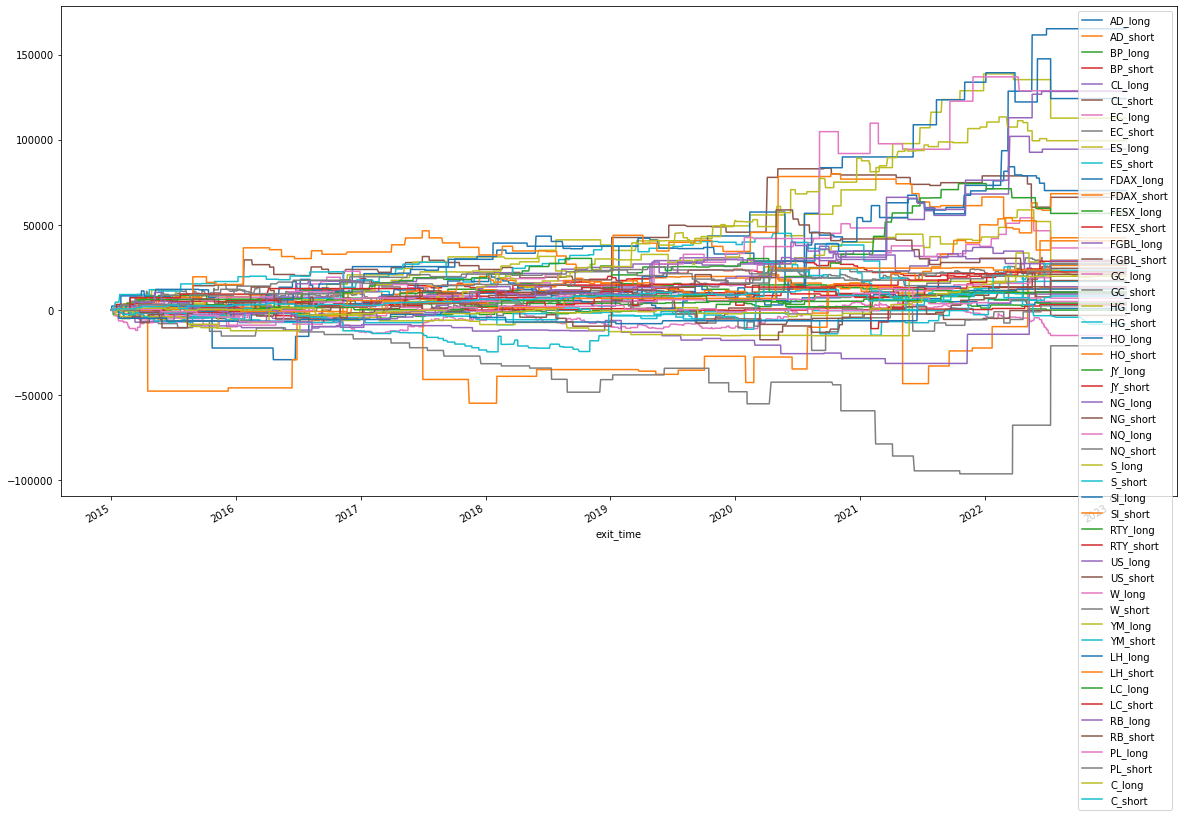

In [23]:
newdf.cumsum().plot(figsize=(20,10))

<AxesSubplot:xlabel='exit_time'>

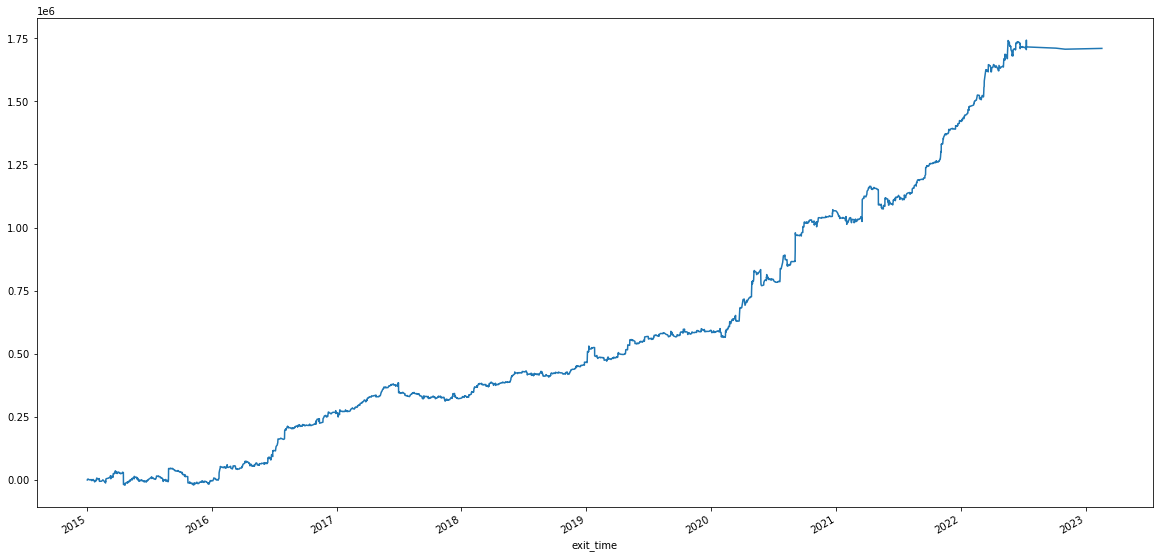

In [24]:
newdf.cumsum().sum(axis=1).plot(figsize=(20,10))

In [25]:
newdf2=pd.DataFrame()

for e in tqdm(valori.Physical.to_list()):
    tmp=[]
    cnt=0
    for e1 in newdf.columns:
        if e in e1:
            tmp.append(e1)
            cnt=1
    if cnt>0:
        tmp_df=newdf[tmp]
        tmp_df=tmp_df.sum(axis=1).to_frame()
        tmp_df.columns=([e])
        newdf2=pd.concat([newdf2,tmp_df],axis=1).fillna(0)
newdf2.tail()  

  0%|          | 0/25 [00:00<?, ?it/s]

,AD,BP,CL,EC,ES,FDAX,FESX,FGBL,GC,HG,...,SI,RTY,US,W,YM,LH,LC,RB,PL,C
exit_time,,,,,,,,,,,,,,,,,,,,,
2022-07-12 00:00:00,0.0,0.0,0.0,0.0,-645.0,-23350.0,-645.0,-2860.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-07-28 16:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-10-06 08:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-11-02 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-02-17 16:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
w=newdf2.std()
w=w.to_frame()
w.columns=(["STD"])
w["weigh"]=w.STD.max()
w["app"]=(w.weigh/w.STD).round(2)

newdf3=pd.DataFrame()
for e in newdf2.columns:
    x=w.app[w.index==e].values[0]
    y=newdf2[e].to_frame()
    newdf3=pd.concat([newdf3,y*x],axis=1).fillna(0)
w

,STD,weigh,app
AD,330.705944,2917.40112,8.82
BP,408.946309,2917.40112,7.13
CL,1463.029167,2917.40112,1.99
EC,607.670621,2917.40112,4.80
ES,1122.463916,2917.40112,2.60
FDAX,2917.401120,2917.40112,1.00
FESX,152.090312,2917.40112,19.18
FGBL,448.682450,2917.40112,6.50
GC,1114.446865,2917.40112,2.62
HG,921.276825,2917.40112,3.17


<AxesSubplot:xlabel='exit_time'>

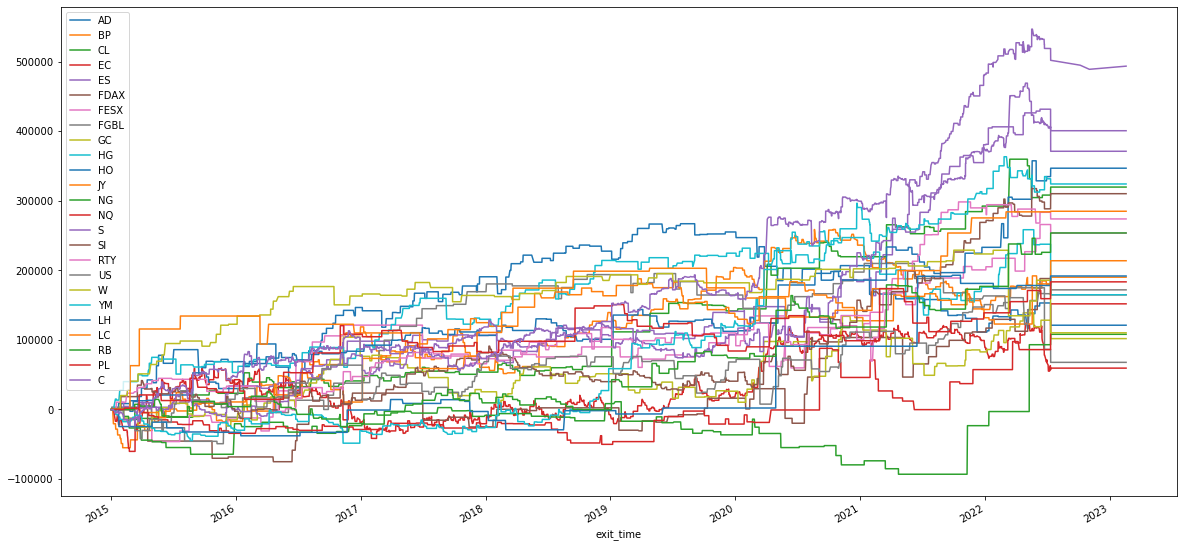

In [27]:
newdf3.cumsum().plot(figsize=(20,10))

<AxesSubplot:xlabel='exit_time'>

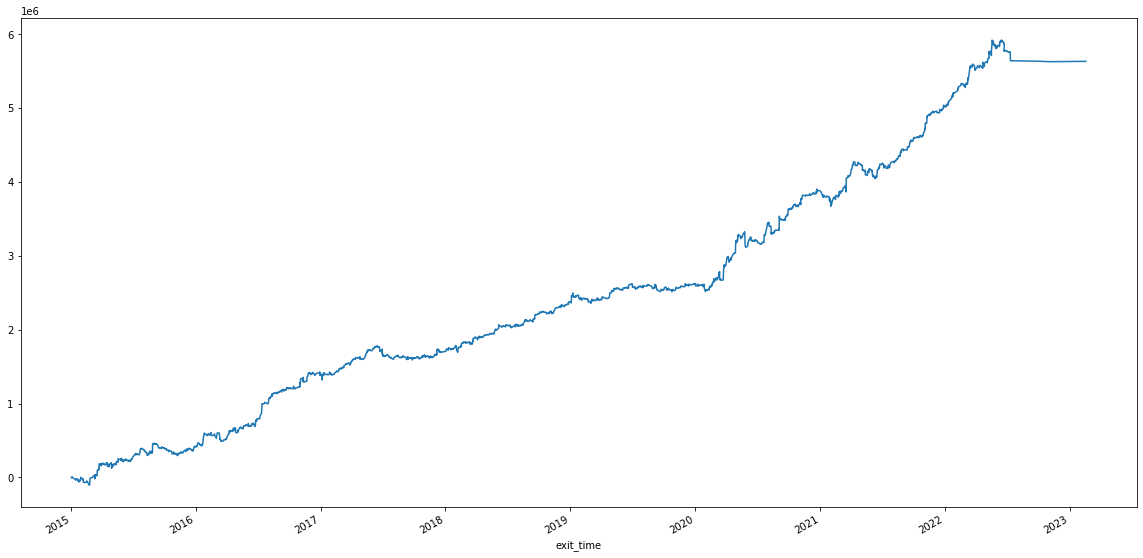

In [28]:
newdf3.sum(axis=1).cumsum().plot(figsize=(20,10))

In [31]:
import os               
os.chdir(r"C:\Users\Drako\Genetico_V3\Strategie_LS")

import uuid

idz = uuid.uuid1()
save_as = "SuperTrend_system_"+RESAMPLE_TF+"_"+str(idz)+".csv"
info.to_csv(save_as)

In [20]:
info

,bigpointvalue,tick,file_name,uct_offset,type_session,resample_tf,start_date,end_date,custom_session_start,custom_session_stop,costi,direzione,tipo_ordine,entry_rules,exit_bars,level,ADD_RULE_CONDITION,TP,SL,exit_rules
0,100000,0.0001,AD,CST6CDT,0,240min,2015-01-01,2023-05-01,0720,1400,25,long,market,"~faster_supertrend_talib(dataset.high, dataset...",0,dataset.close.shift(1),False,0,0,"faster_supertrend_talib(dataset.high, dataset...."
0,100000,0.0001,AD,CST6CDT,0,240min,2015-01-01,2023-05-01,0720,1400,25,short,market,"~faster_supertrend_talib(dataset.high, dataset...",0,dataset.close.shift(1),False,0,0,"faster_supertrend_talib(dataset.high, dataset...."
0,62500,0.0001,BP,CST6CDT,0,240min,2015-01-01,2023-05-01,0720,1400,25,long,market,"faster_supertrend_talib(dataset.high, dataset....",0,dataset.close.shift(1),False,0,0,"~faster_supertrend_talib(dataset.high, dataset..."
0,62500,0.0001,BP,CST6CDT,0,240min,2015-01-01,2023-05-01,0720,1400,25,short,market,"faster_supertrend_talib(dataset.high, dataset....",0,dataset.close.shift(1),False,0,0,"~faster_supertrend_talib(dataset.high, dataset..."
0,1000,0.01,CL,EST5EDT,0,240min,2015-01-01,2023-05-01,0900,1430,50,long,market,"faster_supertrend_talib(dataset.high, dataset....",0,dataset.close.shift(1),False,0,0,"~faster_supertrend_talib(dataset.high, dataset..."
0,1000,0.01,CL,EST5EDT,0,240min,2015-01-01,2023-05-01,0900,1430,50,short,market,"faster_supertrend_talib(dataset.high, dataset....",0,dataset.close.shift(1),False,0,0,"~faster_supertrend_talib(dataset.high, dataset..."
0,125000,0.0001,EC,CST6CDT,0,240min,2015-01-01,2023-05-01,0720,1400,25,long,market,"faster_supertrend_talib(dataset.high, dataset....",0,dataset.close.shift(1),False,0,0,"~faster_supertrend_talib(dataset.high, dataset..."
0,125000,0.0001,EC,CST6CDT,0,240min,2015-01-01,2023-05-01,0720,1400,25,short,market,"faster_supertrend_talib(dataset.high, dataset....",0,dataset.close.shift(1),False,0,0,"~faster_supertrend_talib(dataset.high, dataset..."
0,50,0.25,ES,CST6CDT,0,240min,2015-01-01,2023-05-01,0830,1515,25,long,market,"~faster_supertrend_talib(dataset.high, dataset...",0,dataset.close.shift(1),False,0,0,"faster_supertrend_talib(dataset.high, dataset...."
0,50,0.25,ES,CST6CDT,0,240min,2015-01-01,2023-05-01,0830,1515,25,short,market,"~faster_supertrend_talib(dataset.high, dataset...",0,dataset.close.shift(1),False,0,0,"faster_supertrend_talib(dataset.high, dataset...."
